# TP multimédia - reconnaissance de locuteur

### Examen préliminaire d'une bande son de parole

Installer le logiciel libre Audacity

Charger des fichiers de voix (un de ceux fournis pour la partie supervisée du TP, par exemple, parce qu'ils sont courts), y repérer (à l'oreille et à l'oeil) des phonèmes voisés et non voisés. Il est utile pour cela de zoomer (outil "loupe" sur le menu d'icones Audacity) pour voir plus clairement la forme d'onde audio selon le type de phonème. 


Sélectionner un court segment de son voisé. Attention à ce que votre segment sélectionné soit suffisamment court pour ne contenir que votre phonème-voyelle et pas d'autres sons après-avant, mais suffisamment long pour contenir suffisamment d'oscillations du signal permettre une estimation du spectre. En afficher le spectre (Analyze/Plot spectrum dans le menu Audacity). Sur ce spectre, tenter de repérer les deux premiers formants, notés F1 et F2, (les deux premiers pics principaux dans l'enveloppe du spectre, partant des basses fréquence) et regarder si les valeurs numériques de F1,F2 ou F2-F1 (qui est un peu plus invariant au locuteur que F1 et F2) correspondent approximativement aux indications données dans ( https://en.wikipedia.org/wiki/Formant). Ca n'est pas toujours fiable, vous aurez des résultats plus ou moins convaincants selon vos essais. 

### Classification supervisée d'extraits de parole

Les objectifs et grands principes sont décrits sur https://www.youtube.com/watch?v=uTatLXLUhxM&feature=youtu.be 

Installer le package 

https://github.com/jameslyons/python_speech_features

Le scénario ci-dessous met en concurrence quelques locuteurs, pour une tâche d'apprentissage supervisé de locuteurs.
Avant la classification, on visualise (c'est optionnel mais instructif) :
* les données (du moins, un sous-ensemble des attributs)
* la distribution de probabilité estimée des données, sur chacun des axes


<IPython.core.display.Javascript object>


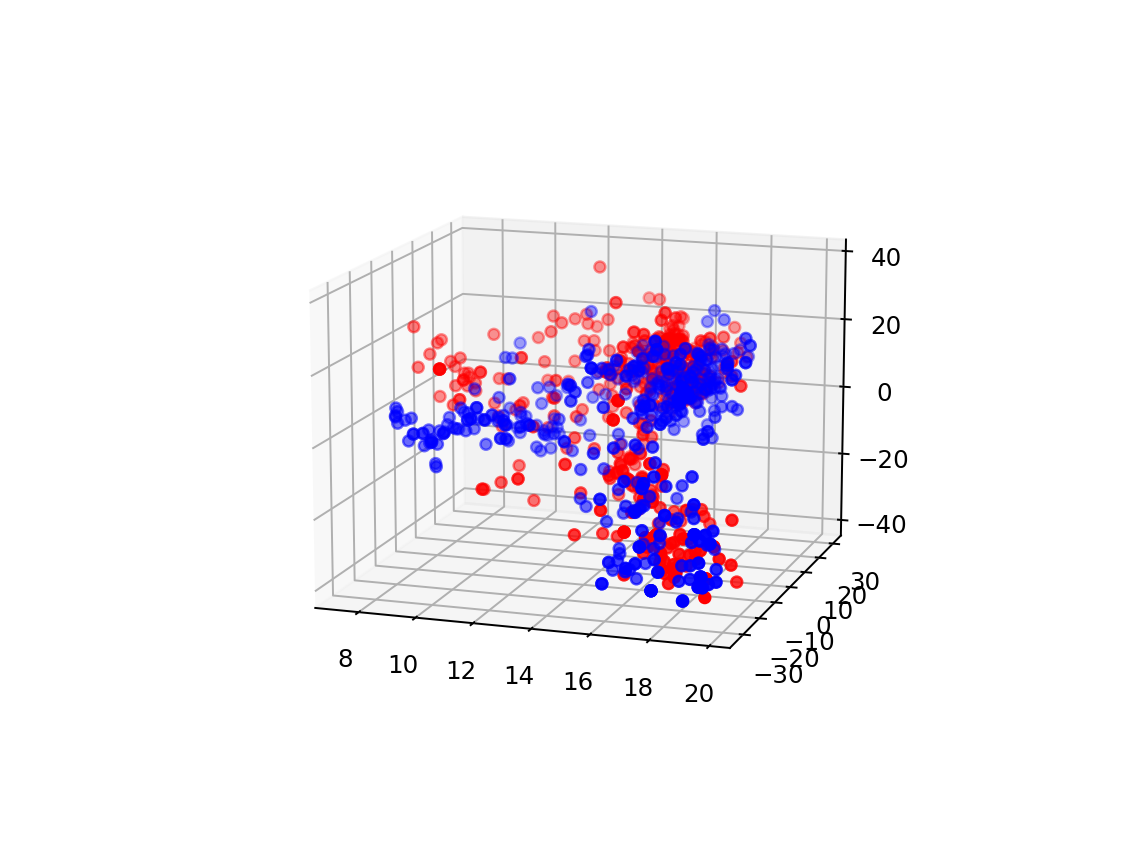

<IPython.core.display.Javascript object>


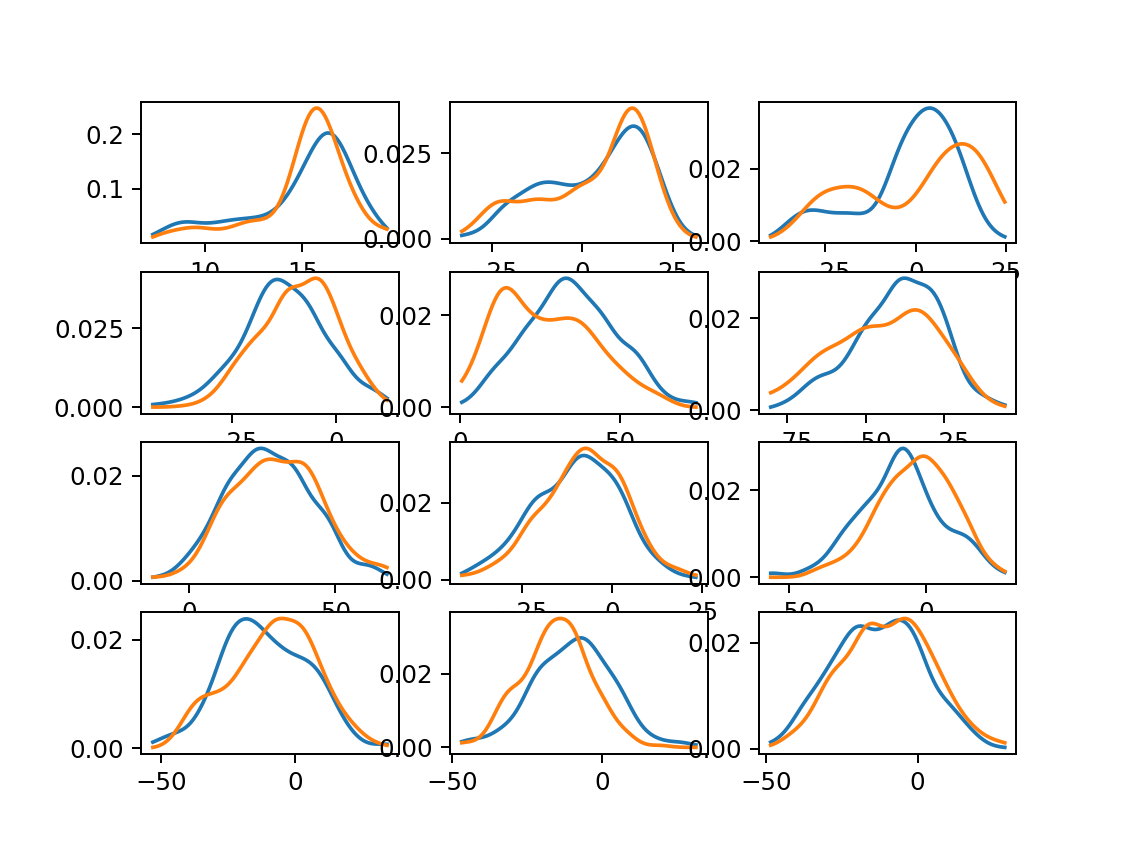

In [11]:

from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

speaker1_filename="hamon1.wav"
speaker2_filename="wauquiez1.wav"
speaker3_filename="philipot1.wav"
speaker4_filename="macron1.wav"
speaker5_filename="melenchon1.wav"

(rate,sig) = wav.read(speaker1_filename)
mfcc_sp1 = mfcc(sig,rate)

(rate,sig) = wav.read(speaker2_filename)
mfcc_sp2 = mfcc(sig,rate)

(rate,sig) = wav.read(speaker3_filename)
mfcc_sp3 = mfcc(sig,rate)

(rate,sig) = wav.read(speaker4_filename)
mfcc_sp4 = mfcc(sig,rate)

(rate,sig) = wav.read(speaker5_filename)
mfcc_sp5 = mfcc(sig,rate)


dmfcc_sp1=mfcc_sp1[np.random.randint(np.shape(mfcc_sp1)[0],size=500),:]
dmfcc_sp2=mfcc_sp2[np.random.randint(np.shape(mfcc_sp2)[0],size=500),:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dmfcc_sp1[:,0],dmfcc_sp1[:,1],dmfcc_sp1[:,2],c='b')
ax.scatter(dmfcc_sp2[:,0],dmfcc_sp2[:,1],dmfcc_sp2[:,2],c='r')

plt.figure()
 
for i in range(12):
    values = mfcc_sp1[np.random.randint(np.shape(mfcc_sp1)[0],size=500),i]
    values2 = mfcc_sp2[np.random.randint(np.shape(mfcc_sp2)[0],size=500),i]
    # 'data' is a 1D array that contains the initial numbers 37231 to 56661
    xmin = min(values)
    xmax = max(values)   

    # get evenly distributed numbers for X axis.
    x = np.linspace(xmin, xmax, 100)   # get 1000 points on x axis
    density = gaussian_kde(values)
    density2 = gaussian_kde(values2)
    ax = plt.subplot(4,3,i+1)
    ax.plot(x, density(x))
    ax.plot(x, density2(x))
    
plt.show()


Résumons maintenant chaque locuteur par son vecteur moyenne et sa matrice de covariance

### Calcul des statistiques descriptives des locuteurs de la base

In [2]:
sp1_mean = np.mean(mfcc_sp1,axis=0)
sp1_cov = np.cov(mfcc_sp1,rowvar=False) # Each column is a variable, each row is an observation
sp2_mean = np.mean(mfcc_sp2,axis=0)
sp2_cov = np.cov(mfcc_sp2,rowvar=False) # Each column is a variable, each row is an observation
sp3_mean = np.mean(mfcc_sp3,axis=0)
sp3_cov = np.cov(mfcc_sp3,rowvar=False) # Each column is a variable, each row is an observation
sp4_mean = np.mean(mfcc_sp4,axis=0)
sp4_cov = np.cov(mfcc_sp4,rowvar=False) # Each column is a variable, each row is an observation
sp5_mean = np.mean(mfcc_sp5,axis=0)
sp5_cov = np.cov(mfcc_sp5,rowvar=False) # Each column is a variable, each row is an observation

Et enfin, évaluons la log-vraisemblance des données d'un nouveau locuteur, et regardons si le classifieur a bien deviné. 

### Evaluation de la vraisemblance pour le locuteurs inconnu, pour chaque modèle de la base

In [22]:
unknown_speaker_filename="melenchon3.wav"
(rate,sig) = wav.read(unknown_speaker_filename)
mfcc_spA = mfcc(sig,rate)


result1 = sum(multivariate_normal.logpdf(mfcc_spA, mean=sp1_mean, cov=sp1_cov))
result2 = sum(multivariate_normal.logpdf(mfcc_spA, mean=sp2_mean, cov=sp2_cov))
result3 = sum(multivariate_normal.logpdf(mfcc_spA, mean=sp3_mean, cov=sp3_cov))
result4 = sum(multivariate_normal.logpdf(mfcc_spA, mean=sp4_mean, cov=sp4_cov))
result5 = sum(multivariate_normal.logpdf(mfcc_spA, mean=sp5_mean, cov=sp4_cov))

print(speaker1_filename,result1)
print(speaker2_filename,result2)
print(speaker3_filename,result3)
print(speaker4_filename,result4)
print(speaker5_filename,result5)



hamon1.wav -62031.64047302588
wauquiez1.wav -54089.12319757788
philipot1.wav -41665.67140409189
macron1.wav -43374.42340153198
melenchon1.wav -38046.41409517294


En ayant teesté les plusieurs enregistrements, la détection fut toujours bonne. Ce sont des probabilités mis sous forme logarithmique, donc la plus grand valeur est la voix la plus probable "la moins négatif"

# Segmentation non supervisée

Ecouter aussi le fichier telenantes.wav pour connaître le contenu de la bande audio sur laquelle on travaille. Cette bande audio n'a rien de particulier, vous pourriez en prendre une autre à la télé ou à la radio.

Regarder l'explication sur https://www.youtube.com/watch?v=ZO6OfXuHPr0&t=3s

**A faire : proposer et écrire dans cette case du notebook une technique mêlant modèles probabilistes gaussiens (tels qu'utilisés dans la partie supervisée) et le principe dont les grandes lignes sont données dans la vidéo ci-dessus. La technique à trouver est déjà programmée ci-dessous **

In [23]:
# Le fichier étant assez long, la quantité de calculs est importante et l execution de cette cellule 
# peut mettre de 5 à 15 secondes selon votre machine

debat_filename="telenantes.wav"
(rate,sig) = wav.read(debat_filename)
mfcc_debat = mfcc(sig,rate)


In [24]:
nb_mfcc_par_seconde=200
debut=0
fin=nb_mfcc_par_seconde*2
largeur=fin-debut
increment=int(largeur/10)
taille = np.shape(mfcc_debat)[0]
ratios= list()
timestamp= list()
it=0

On parcourt la bande audio du début à la fin, en mesurant le rapport entre la vraisemblance de l'hypothèse à 2 modèles et l'hypothèse à 1 modèle.

In [25]:


while fin+2*largeur<taille:
    
    fenetre1       = mfcc_debat[debut           : debut+largeur,     :]
    fenetre2       = mfcc_debat[debut+largeur+1 : debut+2*largeur+1, :]
    fenetre_union  = mfcc_debat[debut           : debut+2*largeur+1, :]
    
    fen1_mean      = np.mean(fenetre1,axis=0)
    fen1_cov       = np.cov(fenetre1,rowvar=False)
    fen1_loglike   = sum(multivariate_normal.logpdf(fenetre1, mean=fen1_mean, cov=fen1_cov))
    
    fen2_mean      = np.mean(fenetre2,axis=0)
    fen2_cov       = np.cov(fenetre2,rowvar=False)
    fen2_loglike   = sum(multivariate_normal.logpdf(fenetre2, mean=fen2_mean, cov=fen2_cov))
    
    fen_union_mean = np.mean(fenetre_union,axis=0)
    fen_union_cov  = np.cov(fenetre_union,rowvar=False)
    fen_union_loglike = sum(multivariate_normal.logpdf(fenetre_union, mean=fen_union_mean, cov=fen_union_cov))
    
    loglik_ratio = fen1_loglike + fen2_loglike - fen_union_loglike
    
    ratios.append(loglik_ratio)
    timestamp.append((debut+largeur)/nb_mfcc_par_seconde)
    debut=debut+increment
    fin=fin+increment
    it=it+1

On affiche maintenant un graphique avec le résultat. L'axe horizontal : le temps en secondes. L'axe vertical : une quantité qui semble être utile pour détecter des changements de locuteurs. Les barres verticales sont les vrais instants de changement de locuteur, tels qu'indiqués dans la variable true_cut. Ces vrais instants ont simplement été obtenus en écoutant le fichier à l'oreille. Leur présence sur le graphique sert à évaluer la qualité de la détection automatique. En modifiant les paramètres du `plt.xlim(0, 250)` par exemple en (150,200), on peut zoomer le résultat pour évaluer plus facilement la qualité sur telle ou telle partie de la séquence

<IPython.core.display.Javascript object>


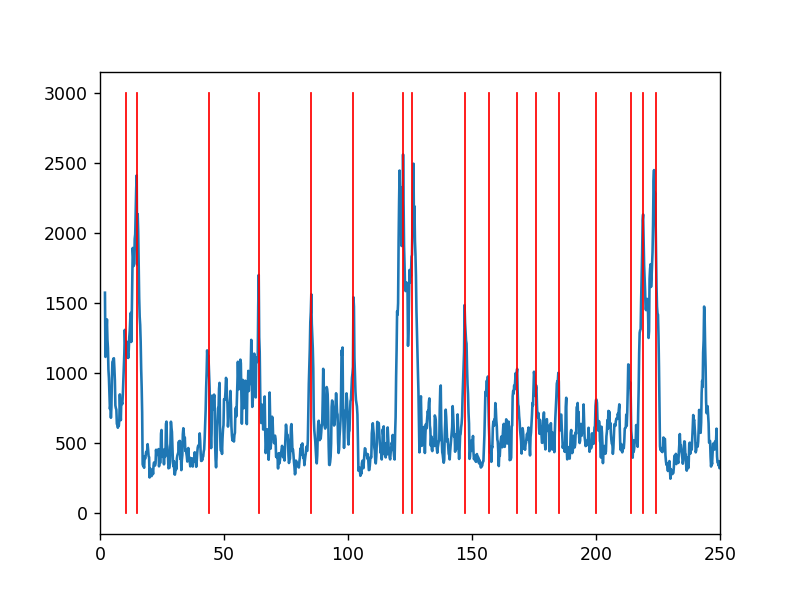

(0.0, 250.0)

In [29]:
plt.figure()
plt.plot(timestamp,ratios)

# True_cut = les instants des vrais changements de locuteur (du moins les premiers, si on est courageux on continue....)
# obtenus en écoutant la bande audio sur Audacity

true_cut= [10.5,15,44,64,85,102,122,126,147,157,168,176,185,200,214,219,224]

# On superpose des traits verticaux aux vrais instants de changement de locuteur
# pour voir si ça correspond bien aux pics
for k in true_cut:
    plt.plot([k, k], [0, 3000], color='r', linestyle='-', linewidth=1)
    
plt.xlim(0, 250) 


**A faire : rédiger une petite analyse de performance de la technique, identifier les situations audio particulières dans le flux qui sont plus susceptibles que d'autres de générer des erreurs.**